# YNet - Dataset 7:

Data from Experiment (2), Mitochondria = Cit1-mCherry 

### Importing utilities:

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [3]:
PATH = "../datasets/yeast_v7/"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO', 'mmm1KO', 'num1KO', 'mfb1KO_num1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

#### Calculating normalization statistics

In [5]:
stats_name = "yeast_v7_per_class.dict"
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
# Xtest = zip(classes['test'])
 
main_stats = Statistics.per_class(train_val, save_name=stats_name)
# test_stats = Statistics.per_class(Xtest, save_name=stats_name)

working on: mfb1KO
working on: mfb1KO
working on: mfb1KO_num1KO
working on: mfb1KO_num1KO
working on: mfb1KO_mmr1KO
working on: mfb1KO_mmr1KO
working on: mmm1KO
working on: mmm1KO
working on: mmr1KO
working on: mmr1KO
working on: WT
working on: WT
working on: num1KO
working on: num1KO


In [6]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

mfb1KO: 	 	 	 (array([0.01453, 0.00456]), array([0.00669, 0.00144]))
mfb1KO_num1KO: 	 	 	 (array([0.00791, 0.0043 ]), array([0.00082, 0.00095]))
mfb1KO_mmr1KO: 	 	 	 (array([0.00789, 0.00471]), array([0.00072, 0.00152]))
mmm1KO: 	 	 	 (array([0.02099, 0.00428]), array([0.00144, 0.00242]))
mmr1KO: 	 	 	 (array([0.01456, 0.00467]), array([0.00672, 0.00156]))
WT: 	 	 	 (array([0.0143, 0.0045]), array([0.00668, 0.00122]))
num1KO: 	 	 	 (array([0.02101, 0.005  ]), array([0.00147, 0.0022 ]))


In [ ]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

## Defining datasets:

In [ ]:
def tfms_for_test(stats, sz):
    test_norm = Normalize(stats)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [7]:
def get_data(path: str, sz, bs):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs)
    main_stats_X = {lbl2index[key]: val for key, val in main_stats.items()}
#     test_stats_X= {lbl2index[key]: val for key, val in test_stats.items()}
    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], pad=sz//8)
#     test_tfms = tfms_for_test(test_stats_X,sz)
#     tfms += (test_tfms, )
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)


In [8]:
data = get_data(PATH,SIZE, BATCH_SIZE)

../datasets/yeast_v7/ {}
../datasets/yeast_v7/ {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mfb1KO_num1KO': 3, 'mmm1KO': 4, 'mmr1KO': 5, 'num1KO': 6}

 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mfb1KO_num1KO': 3, 'mmm1KO': 4, 'mmr1KO': 5, 'num1KO': 6}


In [9]:
x, y = next(iter(data.trn_dl))

### Inspect loaded data:

In [ ]:
# specify which image-index
idx = 60

# loading it from GPU to CPU
xx = x[idx].cpu().numpy().copy()
yy = y[idx]
# showing the image
#
#sp.axis('Off')
#sp.set_title("Norm", fontsize=11)
figure, _ ,_ = tiff.imshow(np.sum(xx, axis=0))
figure.set_size_inches(6,6)
figure.add_subplot(111)

figure2, _, _ = tiff.imshow(np.sum(data.trn_ds.denorm(xx,yy).squeeze() * 65536, axis=2))
figure2.set_size_inches(6,6)


# Training setup

In [10]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

In [10]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [11]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [12]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [13]:
wd=1e-5

In [14]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 7), data)

In [15]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [16]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd)

EPOCH 0 ---------------------------------------- STEP 0   
mean: [24.48485 20.06061  3.0303   7.45455  8.90909 29.36364  3.36364]
stdev: [5.58744 5.25668 2.27616 3.14393 3.57062 5.8869  2.26727]

[WT]:  0.0%
[mfb1KO]: 50.0%
[mfb1KO_mmr1KO]:  0.0%
[mfb1KO_num1KO]:  0.0%
[mmm1KO]: 48.57%
[mmr1KO]: 50.0%
[num1KO]: 77.14%
epoch      trn_loss   val_loss   accuracy   
    0      13.122653  17.716727  0.325714  
EPOCH 1 ---------------------------------------- STEP 1   
mean: [24.54545 20.48485  3.0303   7.27273  8.90909 29.36364  3.24242]
stdev: [4.75516 4.60646 2.22227 3.01785 2.66701 4.85435 2.18854]

[WT]:  0.0%
[mfb1KO]:  0.0%
[mfb1KO_mmr1KO]:  0.0%
[mfb1KO_num1KO]: 2.857%
[mmm1KO]: 74.29%
[mmr1KO]: 52.86%
[num1KO]:  0.0%
    1      7.62496    4.075894   0.182857  
EPOCH 2 ---------------------------------------- STEP 2   
mean: [24.54545 20.24242  3.       7.36364  9.0303  29.45455  3.06061]
stdev: [6.12541 4.62556 2.5937  3.00321 3.74558 5.59811 2.26889]

[WT]: 8.571%
[mfb1KO]:  0.0%
[

[array([1.18151]), 0.44]

In [17]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 8   
mean: [24.51515 20.21212  3.       7.36364  8.9697  29.48485  3.18182]
stdev: [5.32644 5.89174 1.95402 2.57985 3.56315 5.23462 2.00688]

[WT]: 24.29%
[mfb1KO]:  0.0%
[mfb1KO_mmr1KO]:  0.0%
[mfb1KO_num1KO]:  0.0%
[mmm1KO]: 100.0%
[mmr1KO]: 100.0%
[num1KO]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      1.111266   2.895869   0.348571  
EPOCH 1 ---------------------------------------- STEP 9   
mean: [24.54545 20.45455  3.15152  7.54545  8.87879 29.15152  3.12121]
stdev: [4.61283 5.47773 2.43859 2.97557 4.05087 5.07592 2.02645]

[WT]: 38.57%
[mfb1KO]: 40.0%
[mfb1KO_mmr1KO]:  0.0%
[mfb1KO_num1KO]: 42.86%
[mmm1KO]: 74.29%
[mmr1KO]: 50.0%
[num1KO]:  0.0%
    1      1.287426   3.536454   0.374286  
EPOCH 2 ---------------------------------------- STEP 10  
mean: [24.45455 20.36364  2.9697   7.48485  9.      29.30303  3.18182]
stdev: [5.34898 4.65682 1.94601 2.70937 3.47284 6.01757 2.13846]

[WT]: 4.286%
[mfb1KO]:  0.0%


EPOCH 22 ---------------------------------------- STEP 30  
mean: [24.93939 20.54545  2.9697   7.51515  8.69697 28.9697   3.39394]
stdev: [5.93367 4.32113 2.40561 3.173   3.91179 5.91088 2.38606]

[WT]: 25.71%
[mfb1KO]: 41.43%
[mfb1KO_mmr1KO]:  0.0%
[mfb1KO_num1KO]: 82.86%
[mmm1KO]: 91.43%
[mmr1KO]: 64.29%
[num1KO]: 28.57%
    22     0.796284   1.370491   0.465714  
EPOCH 23 ---------------------------------------- STEP 31  
mean: [24.45455 20.21212  3.06061  7.69697  9.0303  29.15152  3.27273]
stdev: [4.29299 4.0881  1.84127 3.50311 3.84932 5.06994 1.83026]

[WT]: 70.0%
[mfb1KO]: 24.29%
[mfb1KO_mmr1KO]: 25.71%
[mfb1KO_num1KO]: 97.14%
[mmm1KO]: 85.71%
[mmr1KO]: 65.71%
[num1KO]: 11.43%
    23     0.78894    1.041928   0.54      
EPOCH 24 ---------------------------------------- STEP 32  
mean: [24.33333 20.60606  3.0303   7.33333  9.15152 29.21212  3.21212]
stdev: [5.19129 6.06999 2.27616 3.28141 3.94754 5.22672 2.49554]

[WT]: 97.14%
[mfb1KO]: 32.86%
[mfb1KO_mmr1KO]: 80.0%
[mfb1KO_num1

[WT]: 91.43%
[mfb1KO]: 54.29%
[mfb1KO_mmr1KO]: 80.0%
[mfb1KO_num1KO]: 91.43%
[mmm1KO]: 91.43%
[mmr1KO]: 27.14%
[num1KO]: 60.0%
    44     0.66025    0.719503   0.668571  
EPOCH 45 ---------------------------------------- STEP 53  
mean: [24.87879 20.       3.06061  7.36364  8.93939 29.36364  3.27273]
stdev: [5.44814 6.79126 2.1594  2.87959 2.96382 5.39819 2.10731]

[WT]: 95.71%
[mfb1KO]: 67.14%
[mfb1KO_mmr1KO]: 88.57%
[mfb1KO_num1KO]: 82.86%
[mmm1KO]: 80.0%
[mmr1KO]: 45.71%
[num1KO]: 57.14%
    45     0.648816   0.622621   0.725714  
EPOCH 46 ---------------------------------------- STEP 54  
mean: [24.33333 20.30303  3.0303   7.51515  8.72727 29.33333  3.45455]
stdev: [5.75598 5.01201 2.02237 2.98604 3.45773 5.41975 2.87192]

[WT]: 71.43%
[mfb1KO]: 78.57%
[mfb1KO_mmr1KO]: 62.86%
[mfb1KO_num1KO]: 97.14%
[mmm1KO]: 91.43%
[mmr1KO]: 61.43%
[num1KO]: 57.14%
    46     0.632725   0.630628   0.731429  
EPOCH 47 ---------------------------------------- STEP 55  
mean: [24.72727 20.21212  3.06

    66     0.458805   0.70403    0.745714  
EPOCH 67 ---------------------------------------- STEP 75  
mean: [24.39394 20.36364  3.06061  7.39394  8.69697 29.63636  3.24242]
stdev: [5.97946 4.83559 2.02917 4.33407 4.2318  5.48728 1.95449]

[WT]: 77.14%
[mfb1KO]: 61.43%
[mfb1KO_mmr1KO]: 17.14%
[mfb1KO_num1KO]: 71.43%
[mmm1KO]: 100.0%
[mmr1KO]: 84.29%
[num1KO]: 65.71%
    67     0.438162   0.877241   0.7       
EPOCH 68 ---------------------------------------- STEP 76  
mean: [24.78788 20.12121  3.       7.42424  8.84848 29.54545  3.12121]
stdev: [6.02901 5.0197  2.60536 3.07512 3.35858 6.76932 1.88708]

[WT]: 51.43%
[mfb1KO]: 67.14%
[mfb1KO_mmr1KO]: 14.29%
[mfb1KO_num1KO]: 91.43%
[mmm1KO]: 97.14%
[mmr1KO]: 88.57%
[num1KO]: 54.29%
    68     0.417665   0.767623   0.671429  
EPOCH 69 ---------------------------------------- STEP 77  
mean: [24.69697 20.09091  3.       7.63636  9.12121 29.12121  3.18182]
stdev: [5.07212 4.97487 2.04495 3.69125 3.41793 4.80377 2.36713]

[WT]: 82.86%
[mfb1K

[array([0.45801]), 0.7942857122421265]

In [18]:
learn.save('ResNet_v7_79_1')

In [19]:
%time learn.fit(1e-3, 2, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 88   
mean: [24.87879 20.39394  2.9697   7.33333  8.69697 29.30303  3.15152]
stdev: [5.51449 4.47173 2.08145 2.8885  4.23896 5.46329 2.03189]

[WT]: 61.43%
[mfb1KO]: 80.0%
[mfb1KO_mmr1KO]:  0.0%
[mfb1KO_num1KO]: 74.29%
[mmm1KO]: 100.0%
[mmr1KO]: 81.43%
[num1KO]: 25.71%
epoch      trn_loss   val_loss   accuracy   
    0      0.315137   1.209334   0.645714  
EPOCH 1 ---------------------------------------- STEP 89   
mean: [24.54545 20.36364  2.9697   7.48485  8.9697  29.       3.45455]
stdev: [4.20743 4.43005 1.99218 3.03636 3.23321 5.32006 2.84009]

[WT]: 32.86%
[mfb1KO]: 75.71%
[mfb1KO_mmr1KO]: 20.0%
[mfb1KO_num1KO]: 80.0%
[mmm1KO]: 100.0%
[mmr1KO]: 55.71%
[num1KO]: 51.43%
    1      0.320372   1.407436   0.58      
EPOCH 2 ---------------------------------------- STEP 90   
mean: [24.45455 20.45455  3.       7.39394  8.87879 29.78788  3.18182]
stdev: [3.83043 4.96711 2.3741  3.40178 3.99816 7.26452 2.28903]

[WT]: 60.0%
[mfb1KO]: 

EPOCH 22 ---------------------------------------- STEP 110 
mean: [24.48485 20.33333  2.90909  7.48485  9.0303  29.09091  3.27273]
stdev: [4.44578 5.3692  2.10862 3.48261 3.63055 6.51043 2.1919 ]

[WT]: 71.43%
[mfb1KO]: 92.86%
[mfb1KO_mmr1KO]: 80.0%
[mfb1KO_num1KO]: 91.43%
[mmm1KO]: 91.43%
[mmr1KO]: 70.0%
[num1KO]: 80.0%
    22     0.304536   0.507714   0.811429  
EPOCH 23 ---------------------------------------- STEP 111 
mean: [24.54545 20.51515  2.9697   7.24242  9.12121 29.       3.24242]
stdev: [6.28172 5.36047 2.20859 3.45561 4.04338 6.35801 2.22969]

[WT]: 97.14%
[mfb1KO]: 57.14%
[mfb1KO_mmr1KO]: 74.29%
[mfb1KO_num1KO]: 100.0%
[mmm1KO]: 97.14%
[mmr1KO]: 74.29%
[num1KO]: 82.86%
    23     0.309806   0.450048   0.811429  
EPOCH 24 ---------------------------------------- STEP 112 
mean: [24.60606 20.42424  2.9697   7.54545  8.75758 29.18182  3.15152]
stdev: [4.86135 5.67306 2.36752 2.68656 3.42035 3.49419 2.32407]

[WT]: 84.29%
[mfb1KO]: 71.43%
[mfb1KO_mmr1KO]: 51.43%
[mfb1KO_num1

[array([0.38546]), 0.8314285700661795]

In [20]:
learn.save('ResNet_v7_83_2')

In [26]:
learn.load('ResNet_v7_best_3_1')

In [28]:
%time learn.fit(1e-5, 2, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85), best_save_name='ResNet_v7_best_4')

EPOCH 0 ---------------------------------------- STEP 176  
mean: [24.33333 20.57576  3.24242  7.48485  8.63636 29.27273  3.18182]
stdev: [4.53716 4.36258 2.4867  3.12489 3.51463 4.25884 2.47967]

[WT]: 95.71%
[mfb1KO]: 67.14%
[mfb1KO_mmr1KO]: 74.29%
[mfb1KO_num1KO]: 97.14%
[mmm1KO]: 97.14%
[mmr1KO]: 70.0%
[num1KO]: 80.0%
input an addition to the save path or leave blank to abort
prompt: _1
epoch      trn_loss   val_loss   accuracy   
    0      0.274846   0.402875   0.814286  
EPOCH 1 ---------------------------------------- STEP 177  
mean: [24.9697  20.0303   3.24242  7.57576  8.9697  29.06061  3.21212]
stdev: [5.61105 5.79699 1.90741 3.18167 4.05631 5.69391 2.62572]

[WT]: 48.57%
[mfb1KO]: 87.14%
[mfb1KO_mmr1KO]: 54.29%
[mfb1KO_num1KO]: 94.29%
[mmm1KO]: 100.0%
[mmr1KO]: 58.57%
[num1KO]: 80.0%
    1      0.294413   0.855154   0.717143  
EPOCH 2 ---------------------------------------- STEP 178  
mean: [24.54545 20.06061  2.9697   7.39394  8.90909 29.66667  3.30303]
stdev: [3.86194 6

[WT]: 64.29%
[mfb1KO]: 92.86%
[mfb1KO_mmr1KO]: 65.71%
[mfb1KO_num1KO]: 94.29%
[mmm1KO]: 100.0%
[mmr1KO]: 74.29%
[num1KO]: 60.0%
    20     0.280373   0.523991   0.782857  
EPOCH 21 ---------------------------------------- STEP 197 
mean: [24.51515 20.57576  3.       7.81818  8.87879 28.93939  3.09091]
stdev: [4.69765 5.42737 2.21565 4.4001  3.62448 6.6785  2.39144]

[WT]: 85.71%
[mfb1KO]: 57.14%
[mfb1KO_mmr1KO]: 77.14%
[mfb1KO_num1KO]: 94.29%
[mmm1KO]: 100.0%
[mmr1KO]: 91.43%
[num1KO]: 77.14%
    21     0.282787   0.439777   0.817143  
EPOCH 22 ---------------------------------------- STEP 198 
mean: [24.51515 20.51515  3.12121  7.51515  8.72727 29.06061  3.15152]
stdev: [4.98556 4.93056 2.61415 3.13457 2.75541 5.33678 1.84426]

[WT]: 92.86%
[mfb1KO]: 71.43%
[mfb1KO_mmr1KO]: 68.57%
[mfb1KO_num1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 72.86%
[num1KO]: 82.86%
    22     0.278549   0.381244   0.825714  
EPOCH 23 ---------------------------------------- STEP 199 
mean: [24.57576 20.54545  3.

[array([0.4313]), 0.802857141154153]

### Show loss over time

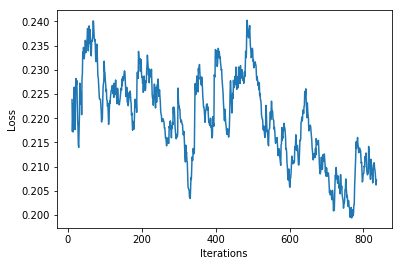

In [23]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

## Analysis

### ...after training 

In [ ]:
## Load model:
learn.load('Objective_A_Resnet_per_class_2')

In [ ]:
%time learn.fit(1e-10, 1, wds=wd, cycle_len=1)

In [ ]:
log_preds, y = learn.TTA() # run predictions with TTA

### Confusion matrix

In [ ]:
# Plot confusion matrix 
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

### Analyse images 

#### Show random correct/incorrectly classified images:

In [ ]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [ ]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [ ]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highes probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x in corr_lbl]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

### Plot images according to predictions

In [ ]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

In [ ]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [ ]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified mmr1KO")

In [ ]:
# etc.

#### Show (most) uncertain images

In [ ]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[:6] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")

# DOES THE MODEL GENERALIZE?????

In [ ]:
def get_test_data(path: str, sz, bs):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='val', test_name='test', test_with_labels=True, bs=bs)
    main_stats_X = {lbl2index[key]: val for key, val in main_stats.items()}
    test_stats_X= {lbl2index[key]: val for key, val in test_stats.items()}
    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    test_tfms = tfms_for_test(test_stats_X,sz)
    tfms += (tfms[0], )
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

In [ ]:
test_data = get_test_data(PATH,SIZE, BATCH_SIZE)

In [ ]:
test_learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 4), test_data)

In [ ]:
test_learn.load('Objective_A_Resnet_per_class_2')

In [ ]:
test_learn.warm_up(1e-14)

In [ ]:
test_log_preds, targs = test_learn.predict_with_targs(is_test=True)
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)
print(preds)
print(targs)

In [ ]:
# Print Accuracy
print(f"accuracy: [{sum(preds == targs) / 70:4.4}]")

In [ ]:
test_log_preds

### Troubleshooting:

In [ ]:
test_x , test_y = next(iter(test_data.test_dl))

In [ ]:
# specify which image-index
idx = 2

# loading it from GPU to CPU
test_xx = test_x[idx].cpu().numpy().copy()
test_yy = test_y[idx]

figure, _ ,_ = tiff.imshow(np.sum(test_xx, axis=0))
figure.set_size_inches(6,6)
figure.add_subplot(111)

figure2, _, _ = tiff.imshow(np.sum(xx, axis=0))
figure2.set_size_inches(6,6)


## Caclulating normalization statistics separately

In [ ]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

In [ ]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

In [ ]:
## Load model:
learn.load('Objective_A_Resnet_per_class_2')

In [ ]:
%time learn.fit(1e-10, 1, wds=wd, cycle_len=1)

In [ ]:
test_log_preds, targs = learn.predict_with_targs(is_test=True)
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)
print(preds)
print(targs)

In [ ]:
# Print Accuracy
print(f"accuracy: [{sum(preds == targs) / 140:4.4}]")

In [ ]:
test_log_preds